##Linkage disequilibrium (LD)

LD (that is, nonindependence of nearby loci due to being physically connected) is used for several purposes: first, to calibrate GWAS-type analyses and designs, because higher linkage disequilibrium means that nearby SNPs may be redundant and you can capture the the same amount of variation with fewer SNPs. Secondly, it is used to infer (well, speculate really) differences in demographic history between different populations.

In our case, the former use may ultimately prove more important but for present purposes we'll focus on just measuring LD in such a way that we can compare it to other indian macaque populations and check that they are broadly consistent. The best published source on macaque LD I've found is [here](http://www.sciencemag.org/content/316/5822/240.long).

One issue when comparing our sample to others is that our monkeys are closely related to each other, which may distort LD estimates. I've found one paper on adjusting LD estimates for known pedigrees, which is [here](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3282397&tool=pmcentrez&rendertype=abstract). However, it is based entirely on treating genotypes as normally distributed and kinship coefficients as correlation coefficients, which is trivially untrue and it's not clear what the consequences of this assumption are.

In [19]:
using RCall,Gadfly,Distributions,Loess,DataFrames
include("../multiallelegibbs.jl");
include("../eigenanlaysis.jl");
include("../singleallelesampler.jl");

Load genotype and pedigree info in from R, preprocessing to remove loci that are not within 300kb of another locus.

In [2]:
rcopy("type='LD'")
rcopy("source('../pedR2jl.R')");
geno = rcopy("X");
ped = rcopy("numped");
dist = rcopy("dist");
rcopy("rm(list=ls())");
rcopy("gc()");

Run sampler.

In [3]:
n,m = size(geno)
iter = 10000;
thin = 20;
nsamp = length(thin:thin:iter);
savepath = "/home/seth/analysis/ppc4ped/LD_";

In [8]:
@time pedfit = pedigree_genogibbs(geno,ped,iter,thin,path=savepath);

elapsed time: 17500.143977137 seconds (5417030375408 bytes allocated, 33.02% gc time)


Load up previous run of samples if needed.

In [4]:
pedfit = pedigree_loadsamp(savepath);
n,m,nsamp = size(pedfit[1]);

Generate posterior predictive distribution (PPD) over genotypes by plugging in MAF samples and simulating genome flow through the pedigree.

In [5]:
genotyped = (sum(geno.!=-1,2).>1)[:];
burnin = 200;
nsim = nsamp - burnin;
ng = countnz(genotyped);

ppgeno = Array(Int8,(n,m,nsim));
for t in 1:nsim
    for j in 1:m
        ppgeno[:,j,t] = pedigree_genosim(ped,pedfit[2][j,t+burnin])[1];
    end
end

nullgeno = Array(Int8,(ng,m,nsim));
for t in 1:nsim
    for j in 1:m
        nullgeno[:,j,t] = rand(Binomial(2,pedfit[2][j,t+burnin]),ng);
    end
end

ppgeno = ppgeno[genotyped,:,:];
impgeno = pedfit[1][genotyped,:,(burnin+1):nsamp];

Now to actually compute the pairwise estimates of LD. There are a bunch of different ways we could go about doing this, the most principled of which would involve fitting more complicated models. But we're going to do it the simplest way and just compute pair-wise correlations between loci for our observed data, and subtract off the correlations observed under the PPD.

We omitt pairs of pairs of genotypes that are farther than 300kb apart, because those correlations are pretty much all zero.

In [6]:
plotty = Array(Float64,(0,3))
r2i = Array(Float64,(0,nsim));
r2p = Array(Float64,(0,nsim));
r2n = Array(Float64,(0,nsim)); 
r2ki = Array(Float64,nsim);
r2kp = Array(Float64,nsim);
r2kn = Array(Float64,nsim);
for i in 1:m
    for j in (i+1):m
        if (dist[i,j] < 3*10^5) & 
            ( abs(mean(pedfit[2][i,:]) - mean(pedfit[2][j,:])) < 0.1)
            for t in 1:nsim
                r2ki[t] = cor(impgeno[:,i,t],impgeno[:,j,t]);
                r2kp[t] = cor(ppgeno[:,i,t],ppgeno[:,j,t]);
                r2kn[t] = cor(nullgeno[:,i,t],nullgeno[:,j,t]);
            end
            r2i = vcat(r2i,r2ki');
            r2p = vcat(r2p,r2kp');
            r2n = vcat(r2n,r2kn');
            plotty = vcat(plotty,[dist[i,j],i,j]');
        end
    end
end
r2i[isnan(r2i)] = 0;
r2p[isnan(r2p)] = 0;
r2n[isnan(r2n)] = 0;
r2c = r2i - r2p;

In [56]:
xpred = collect(minimum(plotty[:,1]):100:maximum(plotty[:,1]));
lofunc = Array(Float64,(length(xpred),nsim))
for t in 1:nsim
    model = loess(plotty[:,1],abs(r2c[:,t]));
    lofunc[:,t] = predict(model,xpred);
end
ylim = Array(Float64,(size(lofunc,1),2));
for i in 1:size(lofunc,1)
    ylim[i,:] = quantile(vec(lofunc[i,:]),[0.025,0.975])'
end

Below is a plot of distance (in base pairs) versus (corrected) absolute correlation. Each point is the posterior correlation for a pair of loci, and the line is the posterior mean of a nonlinear function fit to each sample.

This looks basically as expected, but the LD levels are actually quite a bit higher than what you get if I use the method described in the [reference described above](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=3282397&tool=pmcentrez&rendertype=abstract). It's also barely any different than if we do not correct for the pedigree at all! What's going on here?

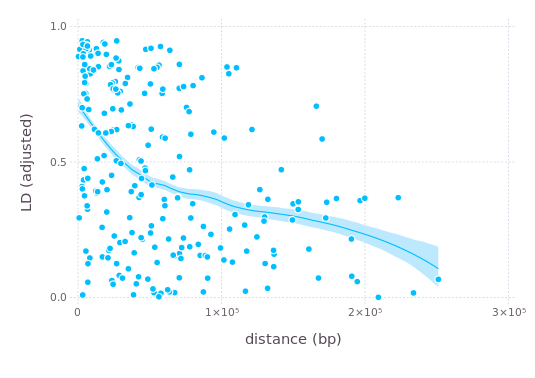

In [57]:
p1 = Gadfly.plot(layer(y=abs(mean(r2c,2)),x=plotty[:,1],Geom.point),
layer(y=mean(lofunc,2),x=xpred,ymin=ylim[:,1],ymax=ylim[:,2],Geom.line,Geom.ribbon),
Guide.xlabel("distance (bp)"),Guide.ylabel("LD (adjusted)"))

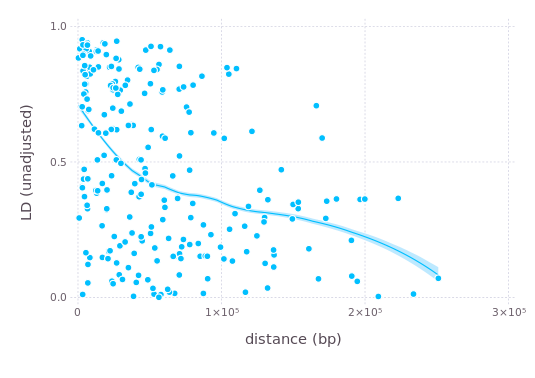

In [55]:
p2 = Gadfly.plot(layer(y=abs(mean(r2i,2)),x=plotty[:,1],Geom.point),
layer(y=mean(lofunc,2),x=xpred,ymin=ylim[:,1],ymax=ylim[:,2],Geom.line,Geom.ribbon),
Guide.xlabel("distance (bp)"),Guide.ylabel("LD (unadjusted)"))

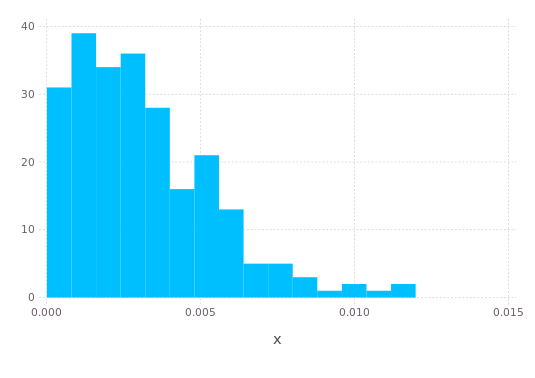

In [49]:
Gadfly.plot(x=abs(mean(r2p,2)),Geom.histogram(bincount=15),)

Above is a histogram of posterior mean correlations from the PPD. As you can see, based on the pedigree alone, any given pair of loci would be expected to have only miniscule LD. 

But what distribution of LD levels would you expect to see in a given sample?

In [16]:
x = 0:0.025:1
countp = Array(Int64,(length(x)-1,nsim));
countn = Array(Int64,(length(x)-1,nsim));
counti = Array(Int64,(length(x)-1,nsim));
for t in 1:nsim
    countp[:,t] = hist(abs(r2p)[:,t],x)[2];
    countn[:,t] = hist(abs(r2n)[:,t],x)[2];
    counti[:,t] = hist(abs(r2i)[:,t],x)[2];
end

Below shows the distribution of LD levels (correlation magnitudes on the x-axis, observed counts on the y) you'd expect within a given sample. The red curve shows what you'd expect if our monkeys were all unrelated and with no LD. The yellow curve is what you would expect if the only source of LD were the pedigree structure. With the pedigree, you'd expect to see a handful of higher LD loci, but it's not a very dramatic increase.

Blue, on the other hand, is what we observe in our sample!

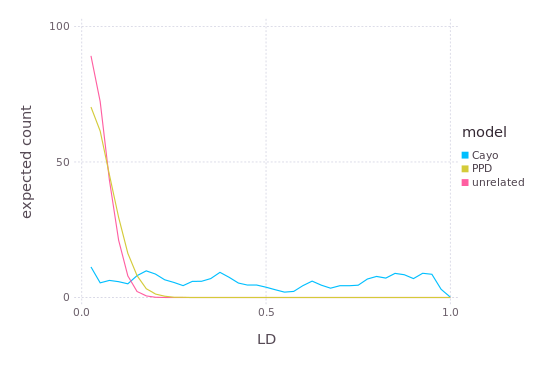

In [60]:
df = DataFrame(count=vcat(mean(counti,2),mean(countp,2),mean(countn,2))[:],
LD=rep(x[2:length(x)],3),model=rep(["Cayo","PPD","unrelated"],1,length(x)-1));

p3 = Gadfly.plot(df,y="count",x="LD",color="model",Geom.line,Guide.ylabel("expected count"))

In conclusion, it doesn't seem like the pedigree structure should impact our estimates of LD much at all. This is very much going against the results of the only proposed method in the literature! I should double check everything of course, but if it holds up it may be an extra impetus to write up a methods paper in addition to the descriptive SNP paper.